# CSCI 3352 Biological Networks, Spring 2020, Prof. Clauset
Submit here: https://moodle.cs.colorado.edu/course/view.php?id=1273

# Problem Set 8 : Protein Interaction Networks

***

**Name**: Julia Sanford

**Worked with**: Denver Chernin

***

This assignment is due on Moodle by **11:55pm on Friday, March 20th**. Your solutions to non-programming questions should be done in Markdown directly below the associated question. Your solutions to computational questions should include any specified Python code and results as well as written commentary on your conclusions.  Remember that you are encouraged to discuss the problems with your classmates, but **you must write all code and solutions on your own** (see syllabus for detailed guidance). There are 70 points total, and 15 pts extra credit.

**NOTES**: 

- Unless a url is given for a data set, you will find the required data on the course Moodle.
- If you're not familiar with typesetting math directly in Markdown, you may do your work on paper first and then typeset it later. This [reference guide](https://math.meta.stackexchange.com/questions/5020/mathjax-basic-tutorial-and-quick-reference) provides helpful guidance for writing math in Markdown. 
- It is **unhelpful** to make your reader interpret numerical output from your code.  If a question asks you to compute some value from the data you should show your code output **AND** write a summary of the results in Markdown directly below your code.

***
* [Documentation for networkx](https://networkx.github.io/documentation/stable/)

[//]: <> (Documentation for igraph Python https://igraph.org/python/ )

In [1]:
import networkx as nx
import numpy as np
import matplotlib
import matplotlib.pylab as plt

%matplotlib inline

In [2]:
def drawGz(G,z):
    # DO NOT MODIFY THIS FUNCTION
    # This function draws G with node labels from partition z
    #
    # input  : G is a networkx graph
    #        : z is a dictionary of group labels for G's nodes
    # output : none
    # 
    # WARNING: function is optimistic: assumes inputs are properly formatted

    colors = ['#d61111','#11c6d6','#d67711','#11d646','#1b11d6','#d611cc'] # map node labels to colors (for the visualization)

    node_colors = []
    for i in G.nodes():
        node_colors.append(colors[int(z[i])])
    nsize  = 600
    flabel = True

    if G.order() > 50:
        nsize  = 100
        flabel = False
        
    nx.draw_networkx(G,with_labels=flabel,node_size=nsize,width=2,node_color=node_colors) # draw it pretty
    limits=plt.axis('off')                                      # turn off axes
    plt.show() 

    return

***
## Problem 1 : Warm ups (20 pts total)

Three warm up exercises, with some new network statistics.

### Problem 1-A (5 pts) : Participation coefficient

The *participation coefficient* $P_i$ is a node-level measure for how much of a node's connectivity is directed inside or outside the module it sits in. This measure was introduced in Guimera et al. "[Functional cartography of complex
metabolic networks.](https://www.nature.com/articles/nature03288)" *Nature* **433** (2005). The mathematical form of $P_i$ was chosen to that $P_i\approx1$ if $i$'s connections are distributed evenly among the modules, and $P_i\approx0$ if $i$'s connections are entirely to nodes in one module (typically its own). You can think of a node's "participation" as measuring how much it participates in *other* modules; hence, a low participation coefficient means *not* connecting to many other modules. It's defined as

$P_i = 1 - \sum_{s=1}^c \left(g_{i,s}\left/k_i\right. \right)^2$

where $s$ runs over the list of groups, $k_i$ is the degree of node $i$, and the variable $g_{i,s}$ counts the number of connections that node $i$ has to any nodes in group $s$, like this:

$g_{i,s} = \sum_j A_{ij}\delta_{s,z_j}$

* For the example graph below (same one as in PS6), calculate by hand the participation coefficients for nodes $0$, $3$, and $5$. Show your work.

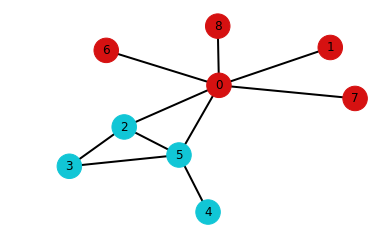

In [3]:
G = nx.Graph([(0,1),(0,2),(0,5),(0,6),(0,7),(0,8),(2,3),(2,5),(4,5),(3,5)]) # a simple graph G
z = {0: 0, 1: 0, 2: 1, 3: 1, 4: 1, 5: 1, 6: 0, 7: 0, 8: 0}                  # a partition of G into 2 groups

drawGz(G,z)

Node $0 = 1 - ((\frac{4}{6})^2 + (\frac{2}{6})^2) = 0.444$ or $\frac{4}{9}$
</br>

Node $3 = 1 - ((\frac{0}{2})^2 + (\frac{2}{2})^2) = 0$
</br>

Node $5 = 1 - ((\frac{1}{4})^2 + (\frac{3}{4})^2) = 0.375$ or $\frac{3}{8}$

### Problem 1-B (5 pts) : Degree $z$-score

Depending on whether a node is higher or lower degree, it may "participate" more or less in the modular structure of the network:

1. A _high-degree_ node with a _low participation_ score is one firmly anchored within its own module, because most of its many connects are to other nodes in its module.
* A _high-degree_ node with a _high participation_ score is one that connects to many other modules.
* Similarly, a _low-degree_ node with a _high participation_ score is likely a kind of "bridge" between a small number of different modules.
* And, a _low-degree_ node with a _low participation_ score is likely a peripheral node within its module.

Because it varies by network what the natural "scale" is by which to say a node is high or low degree, we'll use a simple $z$-score to make the distinction. That is, if a node's degree is above average, we'll call it high degree, and we'll say how high degree it is based on how far out in the tail it is. This degree $z$-score is defined thus:

$z_i = \Big(k_i - \langle k \rangle\Big)\left/\sigma_k\right.$

where $k_i$ is the degree of node $i$, $\langle k \rangle$ is the mean degree in the network, and $\sigma_k$ is the standard deviation of the degrees in the network. $z_i$ thus measures how many standards deviations node $i$'s degree is above or below the mean.

* For the example graph above, calculate by hand the degree $z$-scores for nodes $0$, $3$, and $5$. Show your work.

Hint: Be sure to use the [corrected standard deviation](https://en.wikipedia.org/wiki/Standard_deviation#Corrected_sample_standard_deviation) rather than the uncorrected one.

$s = 1.787$

Node $0 = \frac{6 - \frac{20}{9}}{1.787} = 2.114$
</br>

Node $3 = \frac{2 - \frac{20}{9}}{1.787} = -0.124$
</br>

Node $5 = \frac{4 - \frac{20}{9}}{1.787} = 0.995$

### Problem 1-C (10 pts) : Warm up, by code

* Now write two functions:
  * `calculate_Participation()`, which takes as input a graph $G$, a partition $z$, and a node choice $i$, and returns the participation coefficient $P_i$, and
  * `calculate_DegreezScore()`, which takes as input a graph $G$, and a node choice $i$, and returns the degree $z$-score $z_i$.
* Then apply those functions to verify that you did the by-hand calculations in `Problem 1-A` and `1-B` correctly.

Hint: See the Hint in `Problem 1-B`. Note that the default in `numpy` is the uncorrected estimator.

In [4]:
def calculate_Participation(G,z,i):
    # This function calculates the participation coefficient of node i, given graph G and partition z
    #
    # input  : G, anetworkx simple graph with n nodes
    #        : z is a dictionary of group labels for G's nodes
    #        : i, a node in G
    # output : P_i, the participation coefficient
    # 
    # WARNING: function is optimistic: assumes inputs are properly formatted
    
    ### YOUR CODE (my code: 9 lines, plus return)
    groups = list(set(z.values()))
    group_counts = dict.fromkeys(groups,0)
    for j in G.neighbors(i):
        group_counts[z[j]] += 1
    sum_tot = 0
    degree = G.degree(i)
    for k,v in group_counts.items():
        sum_tot += (v / degree) ** 2
    return round((1 - sum_tot),3)

In [5]:
def calculate_DegreezScore(G,i):
    # This function calculates the degree z-score of node i, given graph G
    #
    # input  : G, anetworkx simple graph with n nodes
    #        : i, a node in G
    # output : z_i, the degree z-score
    # 
    # WARNING: function is optimistic: assumes inputs are properly formatted
    
    ### YOUR CODE (my code: 5 lines, plus return)
    ks = [d[1] for d in G.degree()]
    s_sum = 0; k_mean = sum(ks) / len(ks)
    for k in ks:
        s_sum += (k - k_mean) ** 2
    s = np.sqrt((1/(len(G.nodes)-1)) * s_sum)
    return round(((G.degree(i) - k_mean) / s), 3)

In [6]:
### DO NOT MODIFY THIS BLOCK
Pi = calculate_Participation(G,z,0)
zi = calculate_DegreezScore(G,0)
print(f'P_0 = {Pi}\nz_0 = {zi}\n')

Pi = calculate_Participation(G,z,3)
zi = calculate_DegreezScore(G,3)
print(f'P_3 = {Pi}\nz_3 = {zi}\n')

Pi = calculate_Participation(G,z,5)
zi = calculate_DegreezScore(G,5)
print(f'P_5 = {Pi}\nz_5 = {zi}\n')

P_0 = 0.444
z_0 = 2.114

P_3 = 0.0
z_3 = -0.124

P_5 = 0.375
z_5 = 0.995



***
## Problem 2 : Structural roles in a PPIN (50 pts total)

In this problem, you will
- use the two functions from `Problem 1` to characterize the structural roles that different proteins play in a relatively recent (and thus relatively accurate) estimate of the human protein-protein interaction network (PPIN)
- explore the biological functions of some particular nodes using the [Gene Ontology (GO)](http://geneontology.org) database.

Because this PPIN is pretty large ($n=12,\!250$ nodes), you won't be running your DC-SBM community detection code on it to obtain a partition $z$. That would take a rather long time. Instead, you'll use a partition produced by the DC-SBM implementation in [graph-tool](https://graph-tool.skewed.de).

The PPIN dataset is derived from a _H. sapiens_ network produced by the [Yu lab](http://hint.yulab.org), which combines interaction data from multiple sources, including high-throughput experiments.

### Problem 2-A (15 pts) : Import the network and partition

To begin, import the provided PPIN file `HINT_network.gml` as a `networkx` simple graph $G$, and extract as $z$ the partition included in the GML file.

To do this, you'll need to figure out how to use `networkx` to read in the node attributes included in the GML. Each `node` object has two additional variables associated with it:
* `mb` is the group label or community assigned to it by the DC-SBM (which returned $c=104$ groups), and 
* `ref_id` is an integer index that you'll use to look up the corresponding `gene.name` string of that node in `Problem 2-C`.

For example:

`   node [
      id 1
      mb 1
      ref_id "3727"
   ]`

In [7]:
fname1 = 'HINT_network.gml'
print(f'reading the network file : {fname1}\n')
G = nx.read_gml('./' + fname1, label='id')
print(f'number of nodes = {G.order()}')
print(f'number of edges = {G.size()}')

# here are two clever tricks to see what node attributes G has, which I used to
# verify that the nx.read_gml() function imported the node attributes properly
#set(np.array([list(G.node[n].keys()) for n in G.nodes()]).flatten())
#set([k for n in G.nodes for k in G.nodes[n].keys()])

# YOUR CODE
z = nx.get_node_attributes(G, 'mb')

reading the network file : HINT_network.gml

number of nodes = 12250
number of edges = 58445


### Problem 2-B (15 pts) : Compute and plot $(P_i,z_i)$ pairs

* First, compute and store a pair $(P_i,z_i)$ for each node $i$ in the PPIN.
* Then, make a scatter plot of these values with the degree $z$-scores on the $y$-axis.
* Discuss what you see. Be sure to highlight any unusual patterns, describe where "most" of the data sits, and articulate what this plot tells you about the organization of the PPIN.

Text(0,0.5,'Z-Score')

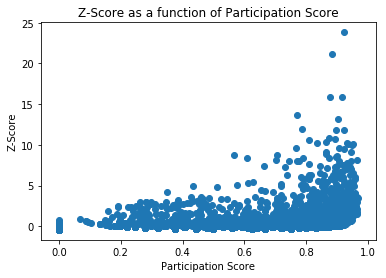

In [8]:
# YOUR CODE
ps = []
zs = []
for i in G.nodes():
    ps.append(calculate_Participation(G,z,i))
    zs.append(calculate_DegreezScore(G,i))
    
plt.scatter(ps, zs)
plt.title("Z-Score as a function of Participation Score")
plt.xlabel("Participation Score")
plt.ylabel("Z-Score")

The data seems to have a an exponential-like curve to it, so most nodes have a pretty low z-score (low degrees) until about 0.6-0.8 participation score, then some nodes have much higher z-scores. Most of the data sits at a high participation score with a z-score around 0-5 meaning that they have relatively low degrees, but they connect to nodes outside of their own group creating the high participation and a bridge-like purpose. There are a few nodes that have low z-scores and low participation scores which are just peripheral nodes within their own group; however, there are some nodes which have high participation and high z-scores which means that they have many connections and connect to many other groups than their own. Since most of the nodes are in the high participation, low z-score category, this means that the overall structure of the graph is not super dense, but could be similar to a dissortative graph because there are so many connections outside of their own groups.

### Problem 2-C (20 pts) : Dig into the details

* Based on the scatter plot in `Problem 2-B`, pick out $10$ nodes that have unusual combinations of participation and degree $z$-scores. Try to choose a variety, if you can. In the markdown box below, make a markdown table with columns for
  * `G.i` (the node's index in $G$),
  * the corresponding `ref_id` value,
  * the `gene.name` associated with that `ref_id` in the provided `all_hint_nodes_names` file, 
  * $P_i$,
  * $z_i$,
  * `GO terms`
  * `GO URL`
* Then, use the [Gene Ontology](http://geneontology.org) database to look up the GO class(es) associated with each, which tell us about which biological functions a protein is involved in. (When you do this, you'll want to select the "Genes and gene products" list of results, or click "Gene products" on the initial search.) 
* List some or all of these in the `GO terms` column (you may omit "protein binding", which is generic), and put the URL for the search results ([like this](http://amigo.geneontology.org/amigo/gene_product/UniProtKB:A2RU48)) in the `GO URL` column.
* Finally, based on your small (and not statistically representative sample) discuss
  1. whether there appears to be any correlation between biological function and either participation or degree $z$-score, and 
  * how you could test this hypothesis computationally. <br/>

*(5 pts extra credit)* For doing $15$ nodes instead of $10$.

Hint: When you look up the GO terms, make sure you select the version of the gene associated with *Homo sapiens*.

In [10]:
# YOUR CODE 
import random
random.seed(1097)
indices = sorted(random.sample(G.nodes(), 15))
all_ref_ids = nx.get_node_attributes(G, 'ref_id')
ref_ids = [all_ref_ids[i] for i in indices]
pis = [ps[i] for i in indices]
zis = [zs[i] for i in indices]

print("Node indices: ")
print(indices)
print("Ref_ids: ")
print(ref_ids)
print("P_i: ")
print(pis)
print("z_i: ")
print(zis)

Node indices: 
[363, 1640, 3346, 4219, 5663, 7065, 7849, 8088, 8619, 8749, 8959, 9059, 9137, 9584, 10101]
Ref_ids: 
['4815', '6926', '11992', '1992', '5304', '11958', '6334', '11372', '5611', '11171', '7740', '6001', '5510', '8065', '5009']
P_i: 
[0.444, 0.925, 0.806, 0.0, 0.72, 0.56, 0.5, 0.656, 0.0, 0.444, 0.5, 0.32, 0.0, 0.612, 0.375]
z_i: 
[-0.334, 0.585, 0.125, -0.436, -0.232, -0.232, -0.385, -0.079, -0.436, -0.334, -0.385, -0.232, -0.436, -0.13, -0.283]


| G.i   | ref_id | gene.name | $P_i$ | $z_i$  | GO terms | GO URL |
| ----- | ------ | --------- | ----- | ------ | -------- | ------ |
| 363   | 4815   | AGK       | 0.444 | -0.334 | anatomical entity, metabolic process, biological process | http://amigo.geneontology.org/amigo/gene_product/UniProtKB:Q53H12 |
| 1640  | 6926   | GPRASP2   | 0.925 |  0.585 | binding, cytoplasm, nucleus | http://amigo.geneontology.org/amigo/gene_product/UniProtKB:Q96D09 |
| 3346  | 11992  | HSF4      | 0.806 |  0.125 | cell development, demethylation, nucleus | http://amigo.geneontology.org/amigo/gene_product/UniProtKB:Q9ULV5 |
| 4219  | 1992   | ZNF7      | 0.000 | -0.436 |  |  |
| 5663  | 5304   | SEZ6L2    | 0.720 | -0.232 | membranes | http://amigo.geneontology.org/amigo/gene_product/UniProtKB:Q6UXD5 |
| 7065  | 11958  | SEC14L4   | 0.560 | -0.232 | lipid binding | http://amigo.geneontology.org/amigo/gene_product/UniProtKB:Q9UDX3 |
| 7849  | 6334   | UBALD1    | 0.500 | -0.385 |  |  |
| 8088  | 11372  | BCOR      | 0.656 | -0.079 | blastocyst hatching, heart development, necluoplasm | http://amigo.geneontology.org/amigo/gene_product/UniProtKB:Q6W2J9 |
| 8619  | 5611   | SLC51A    | 0.000 | -0.436 | bile acid and salt transport, plasma membrane, bile acid secretion | http://amigo.geneontology.org/amigo/gene_product/UniProtKB:Q86UW1 |
| 8749  | 11171  | Q5H970    | 0.444 | -0.334 |  |  |
| 8959  | 7740   | TRMT61B   | 0.500 | -0.385 | mitochondrion, rRNA and tRNA methylation | http://amigo.geneontology.org/amigo/gene_product/UniProtKB:Q9BVS5 |
| 9059  | 6001   | ZCCHC7    | 0.320 | -0.232 | RNA binding, cytosol, nucleolus | http://amigo.geneontology.org/amigo/gene_product/UniProtKB:Q8N3Z6 |
| 9137  | 5510   | DCXR      | 0.000 | -0.436 | extracellular exosome, metabolic processes, nucleus | http://amigo.geneontology.org/amigo/gene_product/UniProtKB:Q7Z4W1 |
| 9584  | 8065   | VPS33B    | 0.612 | -0.130 | HOPS complex, Golgi apparatus, lysosome | http://amigo.geneontology.org/amigo/gene_product/UniProtKB:Q9H267 |
| 10101 | 5009   | VPS53     | 0.375 | -0.283 | Golgi apparatus, cytosol, membrane | http://amigo.geneontology.org/amigo/gene_product/UniProtKB:Q5VIR6 |

(Some proteins were not found for H. Sapiens in the database and were left blank in the table.)

Two of the proteins I found had to deal with membranes, and had very similar z-scores, so it could be possible that proteins in the membrane have similar degrees. This could be tested computationally if you either had all of the GO terms for each protein or if you could easily and quickly look up the GO terms for each protein. If you have all of the GO terms, you could filter by "membrane" and then compare the p- and z-scores to see how close they are. You can find the mean and see how close most of them are to the mean by using standard deviation. If you could easily and quickly look up the GO terms, you could take a small sample, like above, and find the close z-score and filter the proteins by z-scores that are within some standard deviation of that one and from there, you could see if any of those with a close z-score had any interactions within the membrane. 

***
***

## Problem 3 : Reading the literature (*10 pts extra credit*)

Choose a paper from the [Supplemental Reading list on the external course webpage](http://tuvalu.santafe.edu/~aaronc/courses/3352/). Read the paper (the whole paper, not just the abstract). Think about what it says. Then, write 1-3 sentences for each of the following questions in a way that clearly summarizes the work, and its context.
* What paper did you choose?
* What was the research question?
* What was the approach the authors took to answer that question?
* What did they do well?
* What could they have done better?
* What extensions can you envision?


Do not copy any text from the paper itself; write your own summary, in your own words in Markdown in the corresponding box below. Be sure to answer each of the five questions. The amount of extra credit will depend on the accuracy and thoughtfulness of your answers.

Hint: This is a good way to generate some ideas for your class project (your proposal for that is due on **February 27th**. Also, even if you don't understand everything in the paper, that's okay. Do your best to summarize what you did understand.

* *What paper did you choose?*<br/>
M. Huss and P. Holme, **Currency and commodity metabolites: Their identification and relation to the modularity of metabolic networks.** IET Systems Biology 1, 280-285 (2007).
<br/>


* *What was the research question?*<br/>
The researchers say that metabolic networks are usually modular, but they do not always fit perfectly to a modular structure. They study and show that the edges between the modules are necessary for robustness and are not there randomly or unnecessarily.
<br/>

* *What was the approach the authors took to answer that question?*<br/>
They began by constructing a network using the reactants and products of ligands. Then they discussed the algorithms and methods for creating the modules and getting a partition and determining the currency vs commodity metabolites/clusters of nodes. Then, they "ran the numbers" using a human metabolic network showing what kinds of groups there were such as sugar metabolism and amino acid metabolism and protein synthesis discovering the clusters and the connections between the clusters. Lastly, they compared the human clusters to other species. 
<br/>

* *What did they do well?*<br/>
They did a very good job of explaining everything in not too technical of terms, so it was very easy to understand and follow their experiment. 
<br/>

* *What could they have done better?*<br/>
I think they could have included a little bit more data for the human graph and another image for the comparison of other species because I only got the visual for the human, and little data, then I only saw data for other species which is a little bit harder to interpret than an image and data. 
<br/>

* *What extensions can you envision?*<br/>
I think they could expand upon the connections between the modules and the significance of that part of the graph. They could also do a similar model for other structures of modular graphs such as disassortative graphs or even ordered or core-periphery to see if their are more correlations among those networks between species. 